In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets

In [3]:
# Load Data from MNIST
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# Add Channel dimension
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

# Data Normalization
X_train, X_test = X_train/255., X_test/255.

In [4]:
inputs = layers.Input((28, 28, 1))
l = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
l = layers.Activation('relu')(l)
l = layers.Conv2D(32, (3, 3), padding='SAME')(l)
l = layers.Activation('relu')(l)
l = layers.MaxPool2D(pool_size=(2, 2))(l)
l = layers.Dropout(0.25)(l)

l = layers.Conv2D(64, (3, 3), padding='SAME')(l)
l = layers.Activation('relu')(l)
l = layers.Conv2D(64, (3, 3), padding='SAME')(l)
l = layers.Activation('relu')(l)
l = layers.MaxPool2D(pool_size=(2, 2))(l)
l = layers.Dropout(0.25)(l)

l = layers.Flatten()(l)
l = layers.Dense(512)(l)
l = layers.Activation('relu')(l)
l = layers.Dropout(0.25)(l)
l = layers.Dense(10)(l)
l = layers.Activation('softmax')(l)

model = tf.keras.Model(inputs=inputs, outputs=l, name='cnn-v1')

### tf.data

In [5]:
# Generator
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(32)

#### next(iter({generator}))

In [6]:
image, label = next(iter(train_ds))
image.shape, label.shape

(TensorShape([32, 28, 28, 1]), TensorShape([32]))

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

#### train_ds.take()

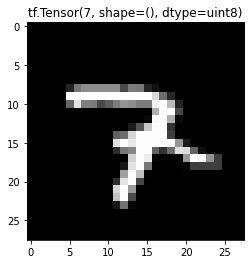

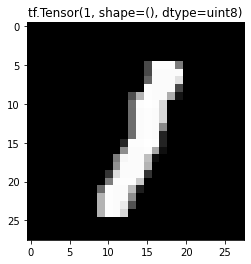

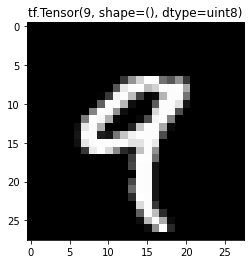

In [8]:
for image, label in train_ds.take(3):
    plt.title(str(label[0]))
    plt.imshow(image[0, :, :, 0], 'gray')
    plt.show()

### Training (Keras)

```Python3
model.compile()
mode.fit()
```

### Optimization
* Loss Function
* Optimizer

#### Set Object

In [9]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [10]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### Training (Expert)
* @tf.function : 기존 session 열었던 것 처럼 바로 작동하는것이 아니고, 그래프만 만든뒤 학습이 시작되면 돌아가도록 함. -> 속도향상

In [11]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_function(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [12]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_function(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

### Training

In [14]:
for epoch in range(2):
    for images, labels in train_ds:
        train_step(images, labels)
        
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    template = 'Epoch {}, Loss:{}, Accuracy:{}, Test Loss:{}, Test Accuracy{}'
    
    print(template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result() * 100,
                         test_loss.result(),
                         test_accuracy.result() * 100))

Epoch 1, Loss:0.06747666746377945, Accuracy:97.94499969482422, Test Loss:0.035819798707962036, Test Accuracy98.86000061035156
Epoch 2, Loss:0.052963290363550186, Accuracy:98.38777923583984, Test Loss:0.03281724825501442, Test Accuracy98.94000244140625


### Evaluating (Keras)

#### Training(Keras)

In [16]:
num_epochs = 1
batch_size = 64
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=tf.keras.metrics.SparseCategoricalAccuracy())
hist = model.fit(X_train, y_train,
                batch_size=batch_size,
                shuffle=True)

938/938 [==============================] - 101s 108ms/step - loss: 0.0245 - sparse_categorical_accuracy: 0.9920


In [17]:
hist.history

{'loss': [0.024488676339387894],
 'sparse_categorical_accuracy': [0.9920333623886108]}

#### Evaluating
* Evaluate : {model}.evaluate()

In [18]:
model.evaluate(X_test, y_test, batch_size=batch_size)

157/157 [==============================] - 3s 20ms/step - loss: 0.0188 - sparse_categorical_accuracy: 0.9933


[0.01877576671540737, 0.9933000206947327]

#### 결과 확인
* Input으로 들어갈 이미지 데이터 확인

In [19]:
test_image = X_test[0, :, :, 0]
test_image.shape

(28, 28)

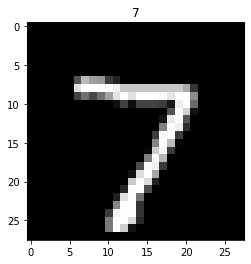

In [20]:
plt.title(y_test[0])
plt.imshow(test_image, 'gray')
plt.show()

#### prediction
* model에 input data로 확인할 이미지 데이터 넣기
* {model}.predict()

In [23]:
test_image = test_image.reshape(1, 28, 28, 1)
pred = model.predict(test_image)
print(pred.shape)
print(pred) # softmax value

(1, 10)
[[1.11937566e-13 3.32547856e-09 4.16665547e-09 7.28154559e-09
  8.00550338e-12 8.60146698e-13 8.12039171e-17 1.00000000e+00
  2.18023447e-11 5.16602894e-09]]


#### np.argmax()

In [25]:
import numpy as np
np.argmax(pred)

7

#### Test Batch
* Batch로 Test 하기

In [26]:
test_batch = X_test[:32]
test_batch.shape

(32, 28, 28, 1)

* Batch Test Dataset을 모델에 넣기

In [27]:
preds = model.predict(test_batch)
preds.shape

(32, 10)

In [28]:
preds

array([[1.11937993e-13, 3.32548500e-09, 4.16667145e-09, 7.28155980e-09,
        8.00550338e-12, 8.60145071e-13, 8.12042281e-17, 1.00000000e+00,
        2.18023447e-11, 5.16603915e-09],
       [1.32491448e-10, 3.64268643e-10, 1.00000000e+00, 7.44043282e-12,
        1.31505896e-12, 3.81086730e-14, 1.44354431e-08, 1.27563141e-10,
        2.42603732e-11, 1.37877470e-12],
       [7.59068186e-09, 9.99997973e-01, 8.66603589e-09, 7.41393447e-10,
        1.13752833e-07, 1.64849183e-07, 1.29517801e-07, 1.24670669e-06,
        4.29924313e-07, 1.46760852e-08],
       [9.99996781e-01, 7.74223307e-12, 7.97813982e-10, 1.03486060e-10,
        5.39901804e-11, 6.40648734e-09, 3.08125800e-06, 2.86340440e-09,
        1.77074355e-09, 8.22482562e-08],
       [1.27646615e-10, 1.11562026e-09, 2.72778046e-12, 1.73138188e-11,
        9.99790251e-01, 2.36512060e-10, 5.61449665e-10, 4.46553960e-10,
        8.40625070e-10, 2.09763064e-04],
       [1.54233049e-09, 9.99999166e-01, 1.04523046e-09, 5.17079088e-11,
   

#### np.argmax (batch)

In [30]:
np.argmax(preds, -1).shape

(32,)

In [31]:
np.argmax(preds, -1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1])

In [32]:
y_test[0:32]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1], dtype=uint8)